<a href="https://colab.research.google.com/github/Carapet07/Data-Science-projects/blob/main/Temperature_Forecasting(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It's my first project on time series task, all the code I will take from the book: 'Deep learning with python' François Chollet. However I will change it a little, but it's core structure will preserve

The dataset I am going to use is The Jena Climate Dataset. A comprehensive weather time series recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany, spanning from 2009 to 2016. This dataset includes 14 distinct meteorological variables, each measured every 10 minutes, providing detailed insights into the local climate over several years.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [2]:
# Get the data and unzip it
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-01-25 16:29:17--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.200.208, 16.182.103.24, 52.217.231.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.200.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.9MB/s    in 0.7s    

2025-01-25 16:29:18 (18.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
lines[1]

'01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10'

Date Time: Timestamp of the observation.

p (mbar): Atmospheric pressure in millibars.

T (°C): Temperature in degrees Celsius.

Tpot (K): Potential temperature in Kelvin.

Tdew (°C): Dew point temperature in degrees Celsius.

rh (%): Relative humidity percentage.

VPmax (mbar): Maximum vapor pressure.

VPact (mbar): Actual vapor pressure.

VPdef (mbar): Vapor pressure deficit.

sh (g/kg): Specific humidity in grams per kilogram.

H2OC (mmol/mol): Water vapor concentration.

rho (g/m³): Air density in grams per cubic meter.

wv (m/s): Wind speed in meters per second.

max. wv (m/s): Maximum wind speed in meters per second.

wd (deg): Wind direction in degrees.

# Divide the data into 2 numpy arrays:
Temperature data I am going to store column 1 in 'temperature'

And all columns including temeprature in 'raw_data'

In [5]:
temperature = np.zeros(len(lines))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, value in enumerate(lines):
  values = [float(x) for x in value.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [6]:
print(raw_data.shape)
print(temperature.shape)

(420451, 14)
(420451,)


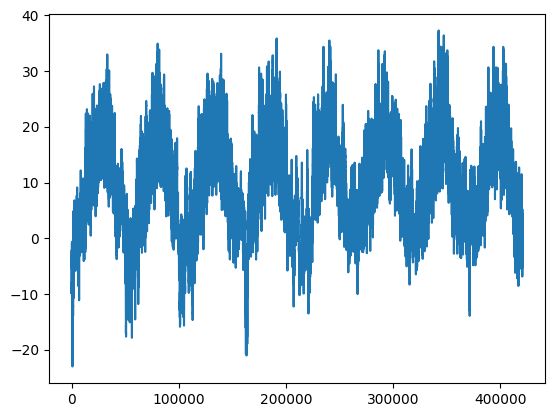

In [7]:
plt.plot(range(len(temperature)), temperature);

This is more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, we get 24 x 6 = 144 data points per day

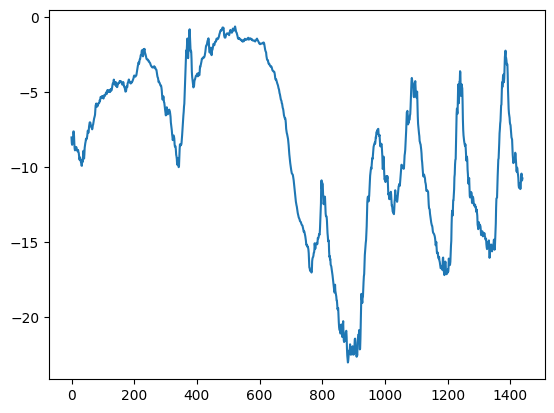

In [8]:
plt.plot(range(1440), temperature[:1440]);

When working with timeseries data, it's important to use more validation and test data, because you're trying to predict the future given the past, not the reverse. And your validation and test splits should reflect that.

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_valid_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_valid_samples

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

print('Num_Train_Samples', num_train_samples)
print('Num_Valid_Samples', num_valid_samples)
print('Num_Test_Samples', num_test_samples)

Num_Train_Samples 210225
Num_Valid_Samples 105112
Num_Test_Samples 105114


In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_test_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_valid_samples
)


Each dataset yields a tuple (samples, targets)

In [11]:
for samples, targets in train_dataset:
  print('train samples: ', samples.shape)
  print('train targets:', targets.shape)
  break

train samples:  (256, 120, 14)
train targets: (256,)


256 sequences, each sequence contains 120 sampled data points(time steps) and 14 is the number of features in each time step

In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(32, recurrent_dropout=0.3, return_sequences=True))(inputs)
x = layers.Bidirectional(layers.LSTM(64, recurrent_dropout=0.3))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                             save_best_only=True)
]

In [13]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20,
                    callbacks=callbacks)

Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 811s 981ms/step - loss: 23.2077 - mae: 3.5401 - val_loss: 9.6814 - val_mae: 2.3958
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 798s 974ms/step - loss: 10.5684 - mae: 2.5374 - val_loss: 9.5278 - val_mae: 2.3870
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 823s 1s/step - loss: 9.5366 - mae: 2.4141 - val_loss: 9.8107 - val_mae: 2.4164
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 807s 985ms/step - loss: 8.5988 - mae: 2.2989 - val_loss: 10.4647 - val_mae: 2.4995
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 794s 970ms/step - loss: 7.8083 - mae: 2.1861 - val_loss: 10.7190 - val_mae: 2.5315
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 802s 969ms/step - loss: 7.1023 - mae: 2.0804 - val_loss: 10.9213 - val_mae: 2.5604
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 799s 966ms/step - loss: 6.6503 - mae: 2.0083 - val_loss: 11.1098 - val_mae: 2.5782
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 788s 963ms/step - loss: 6.1534 - mae: 1.9350 - val_loss: 11.7008 - val_mae: 2.6267
Epoch 9/20
819/819 ━

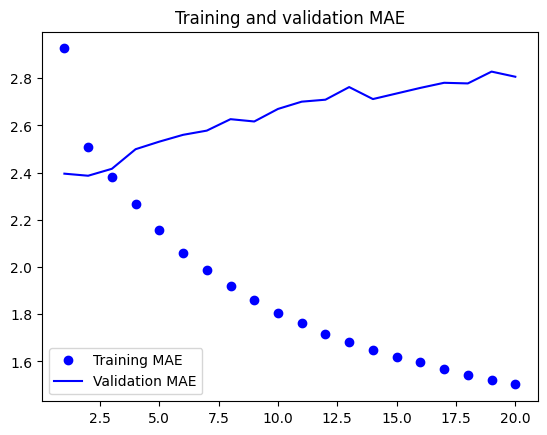

405/405 ━━━━━━━━━━━━━━━━━━━━ 129s 315ms/step
Mean Absolute Error (MAE): 8.7318
Root Mean Squared Error (RMSE): 10.8499


In [14]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


y_pred = model.predict(test_dataset)
y_pred = y_pred.flatten()

y_true = np.concatenate([y for x, y in test_dataset], axis=0)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

We have 420451 data points

In [ ]:
X_train = raw_data[:num_train_samples]
y_train = temperature[delay:num_train_samples + delay]

X_valid = raw_data[num_train_samples: num_train_samples + num_valid_samples]
y_valid = temperature[num_train_samples + delay: num_train_samples + num_valid_samples + delay]

X_test = raw_data[num_train_samples + num_valid_samples : num_train_samples + num_valid_samples + num_test_samples - delay]
y_test = temperature[num_train_samples + num_valid_samples + delay : num_train_samples + num_valid_samples + num_test_samples]


In [16]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

In [17]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100
}

watchlist = [(dtrain, 'train'), (dval, 'valid')]

evals_result = {}

num_rounds = 100
xgb_model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals = watchlist,
    evals_result = evals_result,
    early_stopping_rounds = 10
)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mae:6.57160	valid-mae:6.21173
[1]	train-mae:6.15442	valid-mae:5.82647
[2]	train-mae:5.80128	valid-mae:5.50614
[3]	train-mae:5.49976	valid-mae:5.22955
[4]	train-mae:5.24656	valid-mae:4.99351
[5]	train-mae:5.03517	valid-mae:4.80488
[6]	train-mae:4.85942	valid-mae:4.65031
[7]	train-mae:4.71469	valid-mae:4.51829
[8]	train-mae:4.59522	valid-mae:4.41345
[9]	train-mae:4.49717	valid-mae:4.33020
[10]	train-mae:4.41693	valid-mae:4.25746
[11]	train-mae:4.35038	valid-mae:4.19741
[12]	train-mae:4.29502	valid-mae:4.15357
[13]	train-mae:4.24958	valid-mae:4.11182
[14]	train-mae:4.21159	valid-mae:4.08193
[15]	train-mae:4.18004	valid-mae:4.05804
[16]	train-mae:4.15399	valid-mae:4.03951
[17]	train-mae:4.13143	valid-mae:4.02530
[18]	train-mae:4.11319	valid-mae:4.01339
[19]	train-mae:4.09765	valid-mae:4.00273
[20]	train-mae:4.08466	valid-mae:3.99585
[21]	train-mae:4.07361	valid-mae:3.98855
[22]	train-mae:4.06409	valid-mae:3.98495
[23]	train-mae:4.05541	valid-mae:3.97981
[24]	train-mae:4.04600	val

In [18]:
print(list(evals_result.keys()))

['train', 'valid']


Mean Absolute Error (MAE): 4.1703
Root Mean Squared Error (RMSE): 5.2806


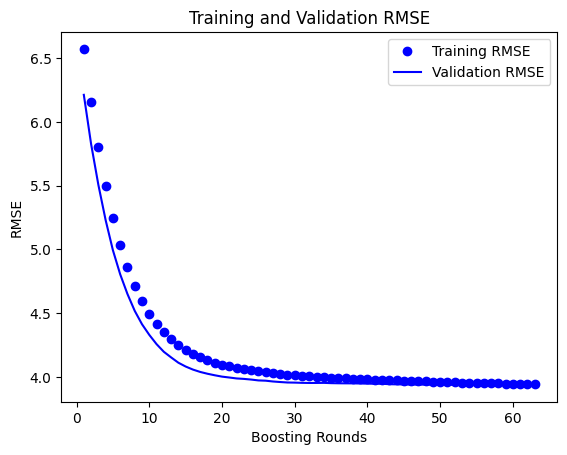

In [19]:
train_rmse = evals_result['train']['mae']
valid_rmse = evals_result['valid']['mae']

epochs = range(1, len(train_rmse) + 1)
plt.figure()
plt.plot(epochs, train_rmse, 'bo', label='Training RMSE')
plt.plot(epochs, valid_rmse, 'b', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.plot()

y_pred = xgb_model.predict(dtest)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")